In [1]:
from keras import backend as K
from keras.models import load_model
import tensorflow as tf
from tensorflow.python.platform import gfile
K.set_learning_phase(0)

Using TensorFlow backend.


In [42]:
model = load_model('./detection4.h5')
print(model.outputs)
# [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
print(model.inputs)

[<tf.Tensor 'conv2d_19_2/Sigmoid:0' shape=(?, 128, 128, 1) dtype=float32>]
[<tf.Tensor 'input_1_1:0' shape=(?, 128, 128, 3) dtype=float32>]


In [43]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

INFO:tensorflow:Froze 567 variables.
INFO:tensorflow:Converted 567 variables to const ops.


In [44]:
tf.train.write_graph(frozen_graph, "model", "detection2.pb", as_text=False)

'model\\detection2.pb'

In [45]:
sess = K.get_session()

In [46]:
f = gfile.GFile("./model/detection2.pb", 'rb')
graph_def = tf.GraphDef()
# Parses a serialized binary message into the current message.
graph_def.ParseFromString(f.read())
f.close()

sess.graph.as_default()
# Import a serialized TensorFlow `GraphDef` protocol buffer
# and place into the current default `Graph`.
tf.import_graph_def(graph_def)

In [8]:
import numpy as np
import cv2

In [47]:
x = np.zeros((2, 128, 128, 3), dtype=np.uint8)

img1 = cv2.imread('./FLASH/Objects_007_flash.png')[:,:,:3]
img1 = cv2.resize(img1, (128,128))
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
x[0] = img1
img = cv2.imread('./AMBIENT/Objects_007_ambient.png')[:,:,:3]
img = cv2.resize(img, (128,128))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
x[1] = img

In [51]:
softmax_tensor = sess.graph.get_tensor_by_name('import/conv2d_19/Sigmoid:0')
predictions = sess.run(softmax_tensor, {'import/input_2:0': x[:2]})

In [52]:
b4 = (predictions>0.5).astype(np.uint8)*255

a=b4[0]-b4[1]
img2=np.zeros_like(img)
img2[:,:,:3]=a
img2[:,:,:1]=a
img2[:,:,:2]=a

In [53]:
from skimage.io import imshow

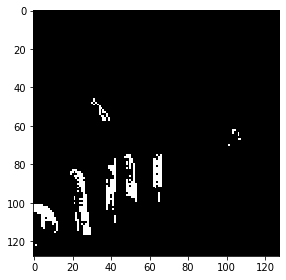

In [54]:
imshow(img2)

In [23]:
n=model.predict(x[:2])

In [31]:
b4 = (n>0.5).astype(np.uint8)*255

a=b4[0]-b4[1]
img2=np.zeros_like(img)
img2[:,:,:3]=n[0]
img2[:,:,:1]=n[0]
img2[:,:,:2]=n[0]

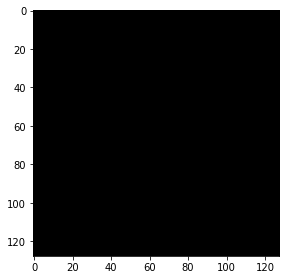

In [32]:
imshow(img2)

In [37]:
m=load_model("./detection4.h5")

In [38]:
for l in m.layers:
    print(l.name)

input_1
lambda_1
conv2d_1
dropout_1
conv2d_2
max_pooling2d_1
conv2d_3
dropout_2
conv2d_4
max_pooling2d_2
conv2d_5
dropout_3
conv2d_6
max_pooling2d_3
conv2d_7
dropout_4
conv2d_8
max_pooling2d_4
conv2d_9
dropout_5
conv2d_10
conv2d_transpose_1
concatenate_1
conv2d_11
dropout_6
conv2d_12
conv2d_transpose_2
concatenate_2
conv2d_13
dropout_7
conv2d_14
conv2d_transpose_3
concatenate_3
conv2d_15
dropout_8
conv2d_16
conv2d_transpose_4
concatenate_4
conv2d_17
dropout_9
conv2d_18
conv2d_19
